In [1]:
!pip install tsplib95

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
# path to datafolder containing the tsp problems
TSP_PATH = "/content/drive/My Drive/uni/NC/tsp/"

In [13]:
#@title AntColony class { display-mode: "form" }
import random as rn
import numpy as np
from numpy.random import choice as np_choice
import time
#import mutator as mut

class AntColony(object):
    def __init__(self, distances, n_ants, timelimit, decay=0.5, alpha=1, beta=5, Q=100, 
                 n_best=None, MEACO=False, rand_start=False, opt=False):
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_iteration (int): Number of iterations
            decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1
        """
        self.distances = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.Q = Q
        self.start_ant = [0] * n_ants
        if rand_start:
          self.start_ant = np_choice(self.all_inds, n_ants)
        self.opt=opt
        # MEACO stuff
        self.MEACO = MEACO
        self.pbest = [("placeholder", np.inf)] * n_ants # holds personal best path
        self.Gbest = ("placeholder", np.inf)

        # keeps track of length shortest path
        self.timelimit = timelimit
        self.history = []  
        self.timestamps = []

    def run(self):
        shortest_path = None
        time_start = time.time()
        while time.time() - time_start < self.timelimit:
            all_paths = self.gen_all_paths()
            shortest_path = min(all_paths, key=lambda x: x[1])
            if shortest_path[1] < self.Gbest[1]:
                self.Gbest = shortest_path
            if self.MEACO:
              mut_path = mutate(self.Gbest[0])
              mut_dist = self.gen_path_dist(mut_path)
              if mut_dist < self.Gbest[1]:
                self.Gbest = (mut_path, mut_dist)
                # update pheromone for route Gbest
                self.spread_pheronome([self.Gbest])
            self.pheromone * self.decay
            self.spread_pheronome(all_paths)
            # keep track of length shortest path
            self.timestamps.append(time.time() - time_start)
            self.history.append(self.Gbest[1])
        return self.Gbest

    def spread_pheronome(self, all_paths):
        if self.n_best is None:
            for path, dist in all_paths:
                for move in path:
                    self.pheromone[move] += self.Q / dist  # 1.0 / self.distances[move]
        else:
            # if n_best has a value, only spread pheromones on the n_best tours
            sorted_paths = sorted(all_paths, key=lambda x: x[1])
            for path, dist in sorted_paths[:self.n_best]:
                for move in path:
                    self.pheromone[move] += self.Q / dist  # 1.0 / self.distances[move]

    def gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for k in range(self.n_ants):
            path = self.gen_path(self.start_ant[k])
            path_dist = self.gen_path_dist(path)

            if self.MEACO:
              if path_dist < self.pbest[k][1]:
                self.pbest[k] = (path, path_dist)
              mut_path = mutate(self.pbest[k][0])
              mut_dist = self.gen_path_dist(mut_path)
              if mut_dist < self.pbest[k][1]:
                self.pbest[k] = (mut_path, mut_dist)
                # update pheromone for route Gbest
                if self.pbest[k][1] < self.Gbest[1]:
                  self.Gbest = self.pbest[k]
                  self.spread_pheronome([self.Gbest])

            if self.opt:
              (path, path_dist) = self.two_opt((path, path_dist))
            all_paths.append((path, path_dist))
        return all_paths

    def gen_path(self, start):
        path = []
        visited = set()  # tabu list
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start))  # going back to where we started
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0  # tabu list
        row = pheromone ** self.alpha * ((1.0 / dist) ** self.beta)
        norm_row = row / row.sum()
        move = np_choice(self.all_inds, 1, p=norm_row)[0]
        return move

    def two_opt(self,path):
      improved =True
      # (0,1) (1,2) (2,1) -> 0,1,2
      route = path_to_array(path[0])
      best_path = path[0]
      best_dist = path[1]
      while improved:
        for i in range(1,len(route)-1):
          for k in range(i+1, len(route)):
            # perform two opt swap
            new_route = route[:i] + route[i:k][::-1] + route[k:]

            new_path = array_to_path(new_route)
            new_dist = self.gen_path_dist(new_path)
            if new_dist < best_dist:
              route=new_route
              best_path = new_path
              best_dist=new_dist
              break; 
            else:
              improved=False 
      return (best_path, best_dist)

In [5]:
#@title Mutator Class { display-mode: "form" }
import numpy as np


def mutate(path):
    path_arr = path_to_array(path)
    mutations = [swap, reversion, insertion]
    mutation = np.random.choice(mutations)
    mutated_path = array_to_path(mutation((path_arr)))
    return mutated_path


def path_to_array(path):
    path_arr = [edge[0] for edge in path]
    return path_arr


def array_to_path(path_arr):
    path = []
    for i in range(len(path_arr) - 1):
        path.append((path_arr[i], path_arr[i + 1]))
    path.append((path_arr[-1], path_arr[0]))
    return path


def swap(path_arr):
    # copy array
    swap_arr = path_arr[::]
    # pick two random indices
    i1, i2 = np.random.choice(range(len(swap_arr)), size=2, replace=False)
    a = swap_arr[i1]
    b = swap_arr[i2]
    swap_arr[i1] = b
    swap_arr[i2] = a
    return swap_arr


def reversion(path_arr):
    # copy array
    rev_arr = path_arr[::]
    # pick two random indices
    i1 = np.random.choice(range(len(rev_arr) - 2))
    # make sure second index is after first
    i2 = np.random.choice(range(i1+2,len(rev_arr)))
    rev_arr[i1:i2] = rev_arr[i1:i2][::-1]
    return rev_arr


def insertion(path_arr):
    ins_arr = path_arr[::]
    # pick two random indices
    i1, i2 = np.random.choice(range(len(ins_arr)), size=2, replace=False)
    # insert p[i2] after i1
    ins_arr.insert(i1, ins_arr.pop(i2))
    return ins_arr


In [6]:
#@title Other functions

import tsplib95
import networkx
import matplotlib.pyplot as plt

def load_tsp(tsp_name): 
  problem = tsplib95.load(TSP_PATH+ tsp_name + ".tsp")
  # convert into a networkx.Graph
  graph = problem.get_graph()
  # convert into a numpy distance matrix
  distance_matrix = np.asarray(networkx.to_numpy_matrix(graph))
  # Change diagonal to np.inf, this is needed in order to use ant_colony.py
  np.fill_diagonal(distance_matrix,  np.inf)
  return distance_matrix

def show_history(history, timestamps):
  '''
  history (numpy.array): Array with history of shortest path length found
  '''
  plt.figure()
  plt.plot(timestamps, history)
  plt.xlabel("time elapsed")
  plt.ylabel("Distance")

def compare_history(aco_instances, labels):
  '''
  Example:
    aco = AntColony(tsp, n_ants=n_ants, timelimit=timelimit)
    meaco = AntColony(tsp, n_ants=n_ants, timelimit=timelimit, MEACO= True)
    compare_history(aco_instances=[aco,meaco] , labels=["ACO","MEACO"])
  '''
  plt.figure()
  for i, aco in enumerate(aco_instances):
      plt.plot(aco.timestamps, aco.history, marker='.', label=labels[i])
  plt.legend()    
  plt.xlabel("time elapsed")
  plt.ylabel("Distance")

In [8]:
#@title Mutator test
import numpy as np
import time

def mutate_test():
  distances = np.array([[np.inf, 2, 2, 5, 7],
                        [2, np.inf, 4, 8, 2],
                        [2, 4, np.inf, 1, 3],
                        [5, 8, 1, np.inf, 2],
                        [7, 2, 3, 2, np.inf]])

  ant_colony = AntColony(distances, n_ants=14, timelimit=3)


  shortest_path_edges, length = ant_colony.run()



  shortest_path = [edge[0] for edge in shortest_path_edges]
  print ("shorted_path: {}".format(shortest_path))
  print("Length path: {}".format(length))
  print()
  print(shortest_path_edges)

  print(shortest_path)
  print("test array to path, and path to array")
  path= array_to_path(shortest_path)
  print(path)
  print(path_to_array(path))
  print()
  print("test swap")
  print(shortest_path)
  swapped = swap(path_arr=shortest_path)
  print(swapped )
  print(shortest_path)
  print()
  print("test reversion")
  print(shortest_path)
  rev = reversion(path_arr=shortest_path)
  print(rev )
  print(shortest_path)
  print()
  print("test insertion")
  print(shortest_path)
  inserted = insertion(path_arr=shortest_path)
  print(inserted )
  print(shortest_path)
  print()
  print("test mutation")
  print(shortest_path_edges)
  mutated = mutate(path=shortest_path_edges)
  print(mutated )

  print()
  print("Output as list:")
  print(path_to_array(shortest_path_edges))
  print(path_to_array(mutated))
#mutate_test()

ACO
shorted_path: [1, 8, 16, 13, 14, 12, 7, 6, 10, 9, 11, 5, 15, 4, 2, 3]
Length path: 7004.0

MEACO
shorted_path: [8, 1, 16, 12, 13, 14, 7, 6, 15, 5, 11, 9, 10, 3, 2, 4]
Length path: 6913.0

Rand Start MEACO
shorted_path: [9, 10, 3, 2, 4, 8, 1, 16, 13, 14, 12, 7, 6, 15, 5, 11]
Length path: 6909.0

shorted_path: [15, 1, 8, 4, 2, 3, 16, 12, 13, 14, 6, 7, 10, 9, 11, 5]
Length path: 6870.0



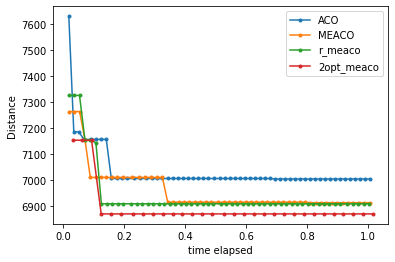

In [14]:
#@title MEACO test { display-mode: "form" }
import numpy as np
import time

tsp_name = "ulysses16"
tsp = load_tsp(tsp_name)
n_ants = int(''.join(i for i in tsp_name if i.isdigit()))
timelimit=1

print("ACO")
aco = AntColony(tsp, n_ants=n_ants, timelimit=timelimit)


time_start = time.time()
shortest_path_edges, length = aco.run()
time_end = time.time()


shortest_path = [edge[0]+1 for edge in shortest_path_edges]
print ("shorted_path: {}".format(shortest_path))
print("Length path: {}".format(length))
print()


meaco = AntColony(tsp, n_ants=n_ants, timelimit=timelimit, MEACO= True)

print("MEACO")
time_start = time.time()
shortest_path_edges, length = meaco.run()
time_end = time.time()
shortest_path = [edge[0]+1 for edge in shortest_path_edges]
print ("shorted_path: {}".format(shortest_path))
print("Length path: {}".format(length))
print()


r_meaco = AntColony(tsp, n_ants=n_ants, timelimit=timelimit, MEACO= True, rand_start=True)

print("Rand Start MEACO")
time_start = time.time()
shortest_path_edges, length = r_meaco.run()
time_end = time.time()
shortest_path = [edge[0]+1 for edge in shortest_path_edges]
print ("shorted_path: {}".format(shortest_path))
print("Length path: {}".format(length))
print()

opt_meaco = AntColony(tsp, n_ants=n_ants, timelimit=timelimit, MEACO=True, opt=True)

shortest_path_edges, length = opt_meaco.run()

shortest_path = [edge[0]+1 for edge in shortest_path_edges]
print ("shorted_path: {}".format(shortest_path))
print("Length path: {}".format(length))
print()

compare_history(aco_instances=[aco,meaco,r_meaco,opt_meaco] , labels=["ACO","MEACO","r_meaco","2opt_meaco"])

In [18]:
def test_aco(tsp_name, timelimit, output_path, iterations=10):
  tsp_name = tsp_name
  tsp = load_tsp(tsp_name)
  n_ants = int(''.join(i for i in tsp_name if i.isdigit()))

  timelimit=timelimit

  all_history = []
  all_timestamps = [] 
  for i in range(iterations):
    ant_colony = AntColony(tsp, n_ants=n_ants, timelimit = timelimit, MEACO=True,opt=True)

    shortest_path, length = ant_colony.run()

    all_history.append(ant_colony.history)
    all_timestamps.append(ant_colony.timestamps)

    
    shortest_path = [edge[0]+1 for edge in shortest_path]
    print ("shorted_path: {}".format(shortest_path))
    print("Length path: {}".format(length))
    show_history(ant_colony.history, ant_colony.timestamps)
  pad = len(max(all_history, key=len))
  to_save_history =  np.array([i + [0]*(pad-len(i)) for i in all_history])
  to_save_timestamps = np.array([i + [0]*(pad-len(i)) for i in all_timestamps])
  np.savetxt(output_path+ '{}MEACO_history.csv'.format(tsp_name), to_save_history, delimiter=',')
  np.savetxt(output_path + '{}MEACO_timestamps.csv'.format(tsp_name), to_save_timestamps, delimiter=',')

shorted_path: [1, 28, 6, 12, 9, 5, 26, 29, 3, 2, 21, 20, 10, 4, 15, 18, 17, 14, 22, 11, 25, 7, 23, 27, 8, 24, 16, 19, 13]
Length path: 2064.0
shorted_path: [1, 28, 6, 12, 9, 5, 26, 29, 3, 2, 20, 10, 4, 15, 18, 17, 14, 22, 11, 25, 7, 23, 8, 27, 24, 16, 19, 13, 21]
Length path: 2057.0
shorted_path: [1, 28, 6, 12, 9, 5, 26, 29, 3, 2, 21, 20, 10, 4, 15, 18, 17, 14, 22, 11, 19, 25, 7, 23, 8, 27, 24, 16, 13]
Length path: 2051.0
shorted_path: [1, 28, 6, 12, 9, 5, 26, 29, 3, 2, 21, 20, 10, 4, 15, 18, 17, 14, 22, 11, 19, 25, 7, 23, 27, 8, 24, 16, 13]
Length path: 2039.0
shorted_path: [1, 28, 6, 12, 9, 5, 26, 29, 3, 2, 21, 20, 10, 4, 15, 18, 17, 14, 22, 11, 19, 25, 7, 23, 27, 8, 24, 16, 13]
Length path: 2039.0
shorted_path: [1, 28, 6, 12, 9, 5, 26, 29, 3, 2, 21, 20, 10, 4, 15, 18, 17, 14, 22, 11, 19, 25, 7, 23, 27, 8, 24, 16, 13]
Length path: 2039.0
shorted_path: [1, 28, 6, 12, 9, 5, 26, 29, 3, 2, 21, 20, 10, 4, 15, 18, 17, 14, 22, 11, 25, 7, 23, 27, 8, 24, 16, 19, 13]
Length path: 2064.0
shorte

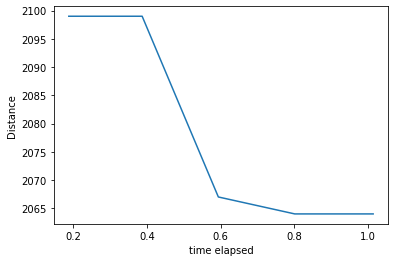

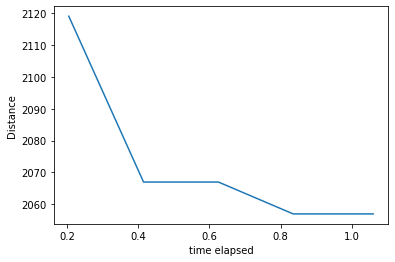

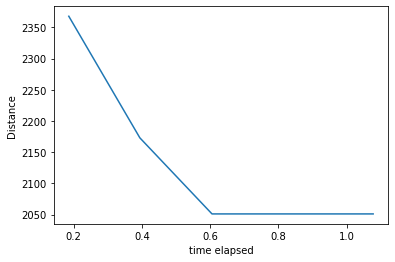

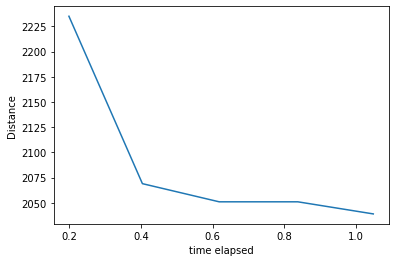

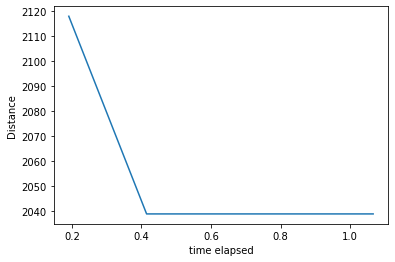

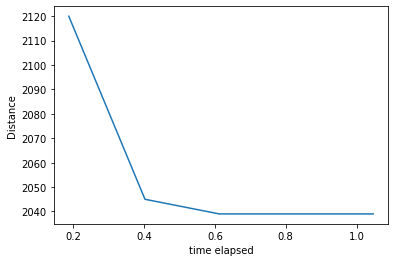

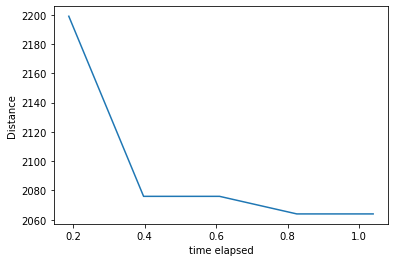

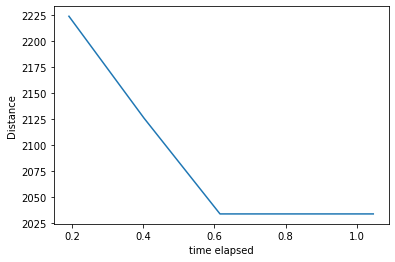

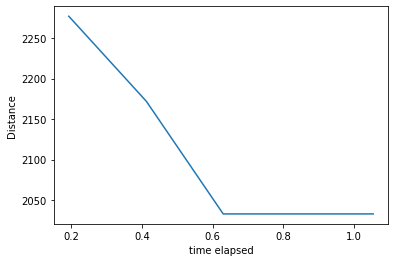

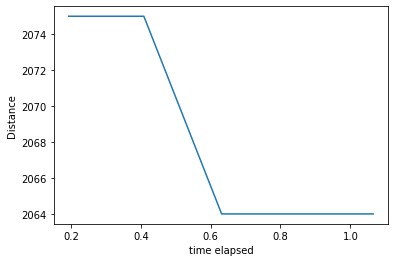

In [20]:
output_path = ''#'/content/drive/My Drive/uni/NC/'
tsp_name = 'bays29'
test_aco(tsp_name=tsp_name, timelimit=1, output_path=output_path)

In [21]:
result = np.loadtxt(output_path + '{}MEACO_timestamps.csv'.format(tsp_name), delimiter=',')
result.shape

(10, 5)